In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
pd.set_option('precision',0)
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
warnings.filterwarnings('ignore')
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1HQ7yFgpOyTmbe9M73RtT_crS9gowmzGt'
downloaded = drive.CreateFile({'id': file_id})

In [ ]:
downloaded.GetContentFile('Total Active Case.xlsx')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

In [ ]:
!pip install -q xlrd

import pandas as pd
df = pd.read_excel('Total Active Case.xlsx')
df

,Date,New_Positive,Flag_Varian,Total_kasus,Sembuh,Meninggal_Dunia
0,2020-03-02,2,covid,2,0,0
1,2020-03-03,0,covid,2,0,0
2,2020-03-04,0,covid,2,0,0
3,2020-03-05,0,covid,2,0,0
4,2020-03-06,2,covid,4,0,0
...,...,...,...,...,...,...
754,2022-03-27,3077,Omicron,5998953,12499,100
755,2022-03-28,2798,Omicron,6001751,10301,104
756,2022-03-29,3895,Omicron,6005646,10092,108
757,2022-03-30,3840,Omicron,6009486,7876,118


In [ ]:
df.describe().style.background_gradient(cmap='prism')

,New_Positive,Total_kasus,Sembuh,Meninggal_Dunia
count,759,759,759,759
mean,7922,1978125,7576,204
std,11915,1880175,10979,337
min,0,2,0,0
25%,908,201688,690,34
50%,4094,1437283,3854,106
75%,7629,4200118,7726,193
max,64718,6012818,61361,2069


In [ ]:
lstm_data = df.groupby(['Date']).agg({'New_Positive':'sum'})
lstm_data

,New_Positive
Date,
2020-03-02,2
2020-03-03,0
2020-03-04,0
2020-03-05,0
2020-03-06,2
...,...
2022-03-27,3077
2022-03-28,2798
2022-03-29,3895


In [ ]:
# lstm_data['lag1']=lstm_data['New_Positive'].shift(1)
# lstm_data['lag2']=lstm_data['New_Positive'].shift(2)
# lstm_data['lag3']=lstm_data['New_Positive'].shift(3)

In [ ]:
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split

# MulVar

In [ ]:
values = lstm_data.values

In [ ]:
# from matplotlib import pyplot
# groups = [0, 1, 2, 3]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(lstm_data.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
from pandas import DataFrame
from pandas import concat
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[1]], axis=1, inplace=True)
print(reframed.head())

   var1(t-2)  var1(t-1)  var1(t)
2      3e-05      0e+00    0e+00
3      0e+00      0e+00    0e+00
4      0e+00      0e+00    3e-05
5      0e+00      3e-05    0e+00
6      3e-05      0e+00    3e-05


In [ ]:
# split into train and test sets
values = reframed.values
split = int(len(df) * 0.8)
train = values[:split, :]
test = values[split:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(607, 1, 2) (607,) (150, 1, 2) (150,)


In [ ]:
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(1)

Epoch 1/50
49/49 [==============================] - 3s 20ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - accuracy: 0.0082 - val_loss: 0.0573 - val_mean_squared_error: 0.0573 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - accuracy: 0.0082 - val_loss: 0.0552 - val_mean_squared_error: 0.0552 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 1s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - accuracy: 0.0082 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - 1s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - accuracy: 0.0082 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 1s 17ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - accuracy:

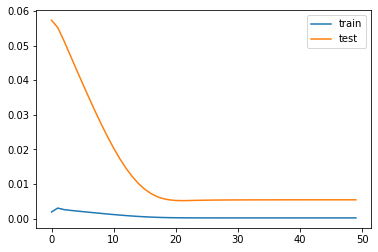

In [ ]:
# design network
model = Sequential()
model.add(LSTM(3, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1,activation='relu'))
model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['mean_squared_error','accuracy'])
from keras.callbacks import ReduceLROnPlateau
batchsize = 10
epochs =  50
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
# fit network
history = model.fit(train_X,
                    train_y,
                    batch_size=batchsize,
                    validation_data=(test_X, test_y),
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.get_weights()

[array([[-0.06643601,  0.651863  ,  0.42918733,  0.20350292, -0.05630964,
          0.38048115,  0.45711994, -0.06235442,  0.15382093,  0.10078067,
          0.1312713 ,  0.10995883,  0.6464035 ,  0.4071621 ,  0.37005666,
         -0.7533278 , -0.16247413, -0.5086767 ,  0.63003236,  0.63504153,
          0.5802905 , -0.15804514, -0.26858202,  0.0581031 ],
        [ 0.02115399,  0.6642195 ,  0.28250566,  0.02408497,  0.27446535,
          0.33075398,  0.3939268 ,  0.06739187, -0.00342557,  0.0902307 ,
          0.03980762, -0.05484337,  0.08168375,  0.5185602 ,  0.7553438 ,
         -0.14682907, -0.39610925, -0.5808749 ,  0.17491305, -0.20277648,
          0.27776146,  0.07440636,  0.38690355,  0.26762748]],
       dtype=float32),
 array([[ 0.0894922 , -0.16966963, -0.07445562, -0.09338514,  0.18901503,
         -0.10482002,  0.01077249,  0.19350302,  0.4398159 , -0.55860853,
         -0.08237159,  0.03116472,  0.01148524, -0.00480394,  0.16536449,
         -0.24815644,  0.25007018,  0.

# Test

In [ ]:
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mse = mean_squared_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test RMSE: %.3f' % mse)

Test RMSE: 5244.907
Test RMSE: 27509052.000


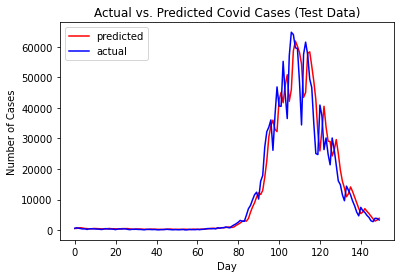

In [ ]:
plt.plot(inv_yhat, color='red')
plt.plot(inv_y, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual']) 

# Train

In [ ]:
# make a prediction
yhat1 = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat1 = concatenate((yhat1, train_X[:, 1:]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y1 = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]


In [ ]:
los=history.history['loss']
acc=history.history['accuracy']
vlos=history.history['val_loss']
vacc=history.history['val_accuracy']

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y1, inv_yhat1))
mse = mean_squared_error(inv_y1, inv_yhat1)
print('Test RMSE: %.3f' % rmse)
print('Test RMSE: %.3f' % mse)

Test RMSE: 2276.798
Test RMSE: 5183810.500


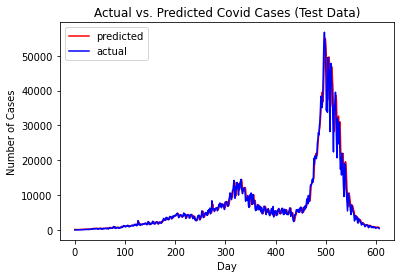

In [ ]:
plt.plot(inv_yhat1, color='red')
plt.plot(inv_y1, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual']) 

MAPE
MAPE	Interpretation
< 10 %	Very good
10 % - 20 %	Good
20 % - 50 %	OK > 50 %	Not good

In [ ]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
# Using MAPE error metrics to check for the error rate and accuracy level
LR_MAPE= MAPE(inv_y,inv_yhat)
print("MAPE: ",LR_MAPE)

MAPE:  37.0970755815506


In [ ]:
coba1=inv_y1+1
coba2=inv_yhat1+1
# Using MAPE error metrics to check for the error rate and accuracy level
RR_MAPE= MAPE(coba1,coba2)
print("MAPE: ",RR_MAPE)

MAPE:  111.24988794326782


#Convert Hasil Forecast to CSV

In [ ]:
forecast = pd.DataFrame(inv_yhat)

In [ ]:
forecast=forecast.round(0)

In [ ]:
forecast=forecast.astype(int)

In [ ]:
forecast.to_csv(index=False)

'0\n562\n584\n777\n809\n668\n558\n512\n452\n422\n545\n552\n512\n476\n445\n385\n373\n515\n560\n477\n469\n454\n357\n374\n511\n510\n500\n524\n439\n326\n328\n386\n389\n380\n344\n324\n269\n288\n361\n344\n308\n308\n301\n241\n245\n297\n309\n346\n364\n303\n253\n271\n301\n262\n267\n326\n286\n208\n289\n341\n293\n286\n320\n330\n313\n377\n440\n551\n615\n591\n590\n587\n691\n817\n793\n897\n1014\n1043\n899\n1101\n1588\n1958\n2372\n2902\n3119\n2963\n3805\n5847\n7550\n8991\n10825\n12199\n11673\n13010\n17358\n22753\n30533\n34108\n35979\n32973\n32222\n42528\n45049\n41666\n47342\n50822\n42151\n45941\n58680\n61822\n60131\n58120\n54282\n43417\n45003\n57835\n58314\n53692\n48730\n42663\n31874\n25903\n32894\n40502\n33763\n29119\n28980\n24260\n26174\n29638\n25102\n19702\n16030\n13783\n10926\n11944\n14148\n12641\n10849\n8960\n7136\n5429\n5945\n7056\n6178\n5433\n4599\n3738\n2993\n3307\n3902\n'

In [ ]:
from google.colab import drive
drive.mount('drive')

MessageError: ignored

In [ ]:
forecast.to_csv('drive/My Drive/forecastlag2V2.csv', sep='.',encoding='utf-8', index=False)

In [ ]:
forecast

Predicting Future

In [ ]:
from numpy import array
x_input=array([[278,311,245],[246,196,130]])
x_input=x_input.reshape(2,3,1)
p=model.predict(x_input,verbose=0)

In [ ]:
scaler.inverse_transform(p)